In [1]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch

torch.backends.cudnn.benchmark = True


In [3]:
def get_device():
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

get_device()

device(type='cuda')

## Wczytywanie zbiboru danych

In [4]:
import os
import random

import torchvision.transforms.v2 as v2
from torchvision.transforms import InterpolationMode

from A2D2Dataset import A2D2SegmentationDataset

# transformacje geometryczne
transforms_geo = v2.Compose([ 
    v2.RandomResizedCrop((768, 768), scale=(0.5, 2.0), interpolation=InterpolationMode.NEAREST),
    v2.RandomHorizontalFlip(p=0.5),    
])

# transformacje obrazu (nie stosowane do maski)
transforms_img = v2.Compose([
    v2.ColorJitter(0.2, 0.2, 0.2, 0.1),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root_dir = ".\\data\\camera_lidar_semantic\\"
all_scenes = sorted(
    [d for d in os.listdir(root_dir)
     if os.path.isdir(os.path.join(root_dir, d))]
)

random.seed(42)
all_scenes_copy = all_scenes.copy()
random.shuffle(all_scenes_copy)
train_scenes = all_scenes_copy[:17]
val_scenes   = all_scenes_copy[17:]

# wczytanie datasetu
train_dataset = A2D2SegmentationDataset(
    root_dir=".\\data\\camera_lidar_semantic\\",
    scenes=train_scenes,
    camera="cam_front_center",
    with_meta=False,
    transforms_geo=transforms_geo,
    transforms_img=transforms_img
)

test_dataset = A2D2SegmentationDataset(
    root_dir=".\\data\\camera_lidar_semantic\\",
    scenes=val_scenes,
    camera="cam_front_center",
    with_meta=False,
    transforms_geo=transforms_geo,
    transforms_img=transforms_img
)

c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


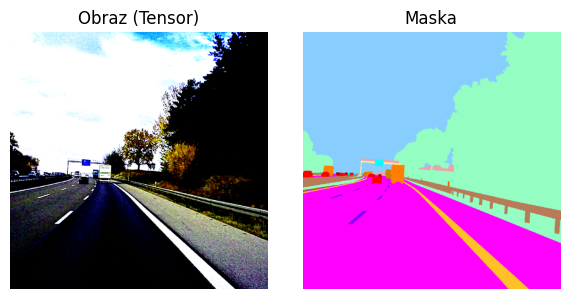

In [5]:
item = test_dataset[10]
image = item['image']    # Tensor [C,H,W]
label = item['label']    # LongTensor [H,W] z indeksami klas

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# obraz (permutacja [C,H,W] → [H,W,C])
img_np = image.permute(1, 2, 0).cpu().numpy()
ax[0].imshow(img_np)
ax[0].set_title("Obraz (Tensor)")
ax[0].axis("off")

# kolorowanie maski
class_id_to_rgb = {v: k for k, v in test_dataset.PALETTE.items()}

lbl_np = label.cpu().numpy()    # [H, W] z wartościami od 0 do (num_classes-1)
H, W = lbl_np.shape
mask_rgb = np.zeros((H, W, 3), dtype=np.uint8)

# łączenie maski
for cls_id, rgb in class_id_to_rgb.items():
    mask_rgb[lbl_np == cls_id] = rgb

ax[1].imshow(mask_rgb)
ax[1].set_title("Maska")
ax[1].axis("off")

# wyświetlenie
plt.tight_layout()
plt.show()

In [6]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

from train import train_model

device = get_device()

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)

train_model(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    ckpt_name="resnet50_test_5",
    device=device
)

Loading checkpoint 'resnet50_test_5'
Resuming from epoch 31


## Generowanie przykładowych obrazów
Po wytrenowaniu modelu należy wprowadzić poniżej nazwę checkpointu oraz ścieżkę do pliku `.png`, na  którym można przetestować działanie modelu.

In [7]:
from mask_generation import generate_segmentation_mask_tiled

generate_segmentation_mask_tiled(
    checkpoint_path=".\\model\\resnet50_test_5.ckpt",
    input_img_path=".\\test\\test2.png",
    tile_size=(768, 768),
    output_path=".\\test\\test2_out8.png",
    overlap=128
    )

RuntimeError: Error(s) in loading state_dict for DeepLabV3:
	Missing key(s) in state_dict: "backbone.conv1.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.conv2.weight", "backbone.layer1.0.bn2.weight", "backbone.layer1.0.bn2.bias", "backbone.layer1.0.bn2.running_mean", "backbone.layer1.0.bn2.running_var", "backbone.layer1.0.conv3.weight", "backbone.layer1.0.bn3.weight", "backbone.layer1.0.bn3.bias", "backbone.layer1.0.bn3.running_mean", "backbone.layer1.0.bn3.running_var", "backbone.layer1.0.downsample.0.weight", "backbone.layer1.0.downsample.1.weight", "backbone.layer1.0.downsample.1.bias", "backbone.layer1.0.downsample.1.running_mean", "backbone.layer1.0.downsample.1.running_var", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.conv2.weight", "backbone.layer1.1.bn2.weight", "backbone.layer1.1.bn2.bias", "backbone.layer1.1.bn2.running_mean", "backbone.layer1.1.bn2.running_var", "backbone.layer1.1.conv3.weight", "backbone.layer1.1.bn3.weight", "backbone.layer1.1.bn3.bias", "backbone.layer1.1.bn3.running_mean", "backbone.layer1.1.bn3.running_var", "backbone.layer1.2.conv1.weight", "backbone.layer1.2.bn1.weight", "backbone.layer1.2.bn1.bias", "backbone.layer1.2.bn1.running_mean", "backbone.layer1.2.bn1.running_var", "backbone.layer1.2.conv2.weight", "backbone.layer1.2.bn2.weight", "backbone.layer1.2.bn2.bias", "backbone.layer1.2.bn2.running_mean", "backbone.layer1.2.bn2.running_var", "backbone.layer1.2.conv3.weight", "backbone.layer1.2.bn3.weight", "backbone.layer1.2.bn3.bias", "backbone.layer1.2.bn3.running_mean", "backbone.layer1.2.bn3.running_var", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.conv2.weight", "backbone.layer2.0.bn2.weight", "backbone.layer2.0.bn2.bias", "backbone.layer2.0.bn2.running_mean", "backbone.layer2.0.bn2.running_var", "backbone.layer2.0.conv3.weight", "backbone.layer2.0.bn3.weight", "backbone.layer2.0.bn3.bias", "backbone.layer2.0.bn3.running_mean", "backbone.layer2.0.bn3.running_var", "backbone.layer2.0.downsample.0.weight", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.1.bias", "backbone.layer2.0.downsample.1.running_mean", "backbone.layer2.0.downsample.1.running_var", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.conv2.weight", "backbone.layer2.1.bn2.weight", "backbone.layer2.1.bn2.bias", "backbone.layer2.1.bn2.running_mean", "backbone.layer2.1.bn2.running_var", "backbone.layer2.1.conv3.weight", "backbone.layer2.1.bn3.weight", "backbone.layer2.1.bn3.bias", "backbone.layer2.1.bn3.running_mean", "backbone.layer2.1.bn3.running_var", "backbone.layer2.2.conv1.weight", "backbone.layer2.2.bn1.weight", "backbone.layer2.2.bn1.bias", "backbone.layer2.2.bn1.running_mean", "backbone.layer2.2.bn1.running_var", "backbone.layer2.2.conv2.weight", "backbone.layer2.2.bn2.weight", "backbone.layer2.2.bn2.bias", "backbone.layer2.2.bn2.running_mean", "backbone.layer2.2.bn2.running_var", "backbone.layer2.2.conv3.weight", "backbone.layer2.2.bn3.weight", "backbone.layer2.2.bn3.bias", "backbone.layer2.2.bn3.running_mean", "backbone.layer2.2.bn3.running_var", "backbone.layer2.3.conv1.weight", "backbone.layer2.3.bn1.weight", "backbone.layer2.3.bn1.bias", "backbone.layer2.3.bn1.running_mean", "backbone.layer2.3.bn1.running_var", "backbone.layer2.3.conv2.weight", "backbone.layer2.3.bn2.weight", "backbone.layer2.3.bn2.bias", "backbone.layer2.3.bn2.running_mean", "backbone.layer2.3.bn2.running_var", "backbone.layer2.3.conv3.weight", "backbone.layer2.3.bn3.weight", "backbone.layer2.3.bn3.bias", "backbone.layer2.3.bn3.running_mean", "backbone.layer2.3.bn3.running_var", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.conv2.weight", "backbone.layer3.0.bn2.weight", "backbone.layer3.0.bn2.bias", "backbone.layer3.0.bn2.running_mean", "backbone.layer3.0.bn2.running_var", "backbone.layer3.0.conv3.weight", "backbone.layer3.0.bn3.weight", "backbone.layer3.0.bn3.bias", "backbone.layer3.0.bn3.running_mean", "backbone.layer3.0.bn3.running_var", "backbone.layer3.0.downsample.0.weight", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.1.bias", "backbone.layer3.0.downsample.1.running_mean", "backbone.layer3.0.downsample.1.running_var", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.conv2.weight", "backbone.layer3.1.bn2.weight", "backbone.layer3.1.bn2.bias", "backbone.layer3.1.bn2.running_mean", "backbone.layer3.1.bn2.running_var", "backbone.layer3.1.conv3.weight", "backbone.layer3.1.bn3.weight", "backbone.layer3.1.bn3.bias", "backbone.layer3.1.bn3.running_mean", "backbone.layer3.1.bn3.running_var", "backbone.layer3.2.conv1.weight", "backbone.layer3.2.bn1.weight", "backbone.layer3.2.bn1.bias", "backbone.layer3.2.bn1.running_mean", "backbone.layer3.2.bn1.running_var", "backbone.layer3.2.conv2.weight", "backbone.layer3.2.bn2.weight", "backbone.layer3.2.bn2.bias", "backbone.layer3.2.bn2.running_mean", "backbone.layer3.2.bn2.running_var", "backbone.layer3.2.conv3.weight", "backbone.layer3.2.bn3.weight", "backbone.layer3.2.bn3.bias", "backbone.layer3.2.bn3.running_mean", "backbone.layer3.2.bn3.running_var", "backbone.layer3.3.conv1.weight", "backbone.layer3.3.bn1.weight", "backbone.layer3.3.bn1.bias", "backbone.layer3.3.bn1.running_mean", "backbone.layer3.3.bn1.running_var", "backbone.layer3.3.conv2.weight", "backbone.layer3.3.bn2.weight", "backbone.layer3.3.bn2.bias", "backbone.layer3.3.bn2.running_mean", "backbone.layer3.3.bn2.running_var", "backbone.layer3.3.conv3.weight", "backbone.layer3.3.bn3.weight", "backbone.layer3.3.bn3.bias", "backbone.layer3.3.bn3.running_mean", "backbone.layer3.3.bn3.running_var", "backbone.layer3.4.conv1.weight", "backbone.layer3.4.bn1.weight", "backbone.layer3.4.bn1.bias", "backbone.layer3.4.bn1.running_mean", "backbone.layer3.4.bn1.running_var", "backbone.layer3.4.conv2.weight", "backbone.layer3.4.bn2.weight", "backbone.layer3.4.bn2.bias", "backbone.layer3.4.bn2.running_mean", "backbone.layer3.4.bn2.running_var", "backbone.layer3.4.conv3.weight", "backbone.layer3.4.bn3.weight", "backbone.layer3.4.bn3.bias", "backbone.layer3.4.bn3.running_mean", "backbone.layer3.4.bn3.running_var", "backbone.layer3.5.conv1.weight", "backbone.layer3.5.bn1.weight", "backbone.layer3.5.bn1.bias", "backbone.layer3.5.bn1.running_mean", "backbone.layer3.5.bn1.running_var", "backbone.layer3.5.conv2.weight", "backbone.layer3.5.bn2.weight", "backbone.layer3.5.bn2.bias", "backbone.layer3.5.bn2.running_mean", "backbone.layer3.5.bn2.running_var", "backbone.layer3.5.conv3.weight", "backbone.layer3.5.bn3.weight", "backbone.layer3.5.bn3.bias", "backbone.layer3.5.bn3.running_mean", "backbone.layer3.5.bn3.running_var", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.conv2.weight", "backbone.layer4.0.bn2.weight", "backbone.layer4.0.bn2.bias", "backbone.layer4.0.bn2.running_mean", "backbone.layer4.0.bn2.running_var", "backbone.layer4.0.conv3.weight", "backbone.layer4.0.bn3.weight", "backbone.layer4.0.bn3.bias", "backbone.layer4.0.bn3.running_mean", "backbone.layer4.0.bn3.running_var", "backbone.layer4.0.downsample.0.weight", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.1.bias", "backbone.layer4.0.downsample.1.running_mean", "backbone.layer4.0.downsample.1.running_var", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.conv2.weight", "backbone.layer4.1.bn2.weight", "backbone.layer4.1.bn2.bias", "backbone.layer4.1.bn2.running_mean", "backbone.layer4.1.bn2.running_var", "backbone.layer4.1.conv3.weight", "backbone.layer4.1.bn3.weight", "backbone.layer4.1.bn3.bias", "backbone.layer4.1.bn3.running_mean", "backbone.layer4.1.bn3.running_var", "backbone.layer4.2.conv1.weight", "backbone.layer4.2.bn1.weight", "backbone.layer4.2.bn1.bias", "backbone.layer4.2.bn1.running_mean", "backbone.layer4.2.bn1.running_var", "backbone.layer4.2.conv2.weight", "backbone.layer4.2.bn2.weight", "backbone.layer4.2.bn2.bias", "backbone.layer4.2.bn2.running_mean", "backbone.layer4.2.bn2.running_var", "backbone.layer4.2.conv3.weight", "backbone.layer4.2.bn3.weight", "backbone.layer4.2.bn3.bias", "backbone.layer4.2.bn3.running_mean", "backbone.layer4.2.bn3.running_var", "classifier.0.convs.0.0.weight", "classifier.0.convs.0.1.weight", "classifier.0.convs.0.1.bias", "classifier.0.convs.0.1.running_mean", "classifier.0.convs.0.1.running_var", "classifier.0.convs.1.0.weight", "classifier.0.convs.1.1.weight", "classifier.0.convs.1.1.bias", "classifier.0.convs.1.1.running_mean", "classifier.0.convs.1.1.running_var", "classifier.0.convs.2.0.weight", "classifier.0.convs.2.1.weight", "classifier.0.convs.2.1.bias", "classifier.0.convs.2.1.running_mean", "classifier.0.convs.2.1.running_var", "classifier.0.convs.3.0.weight", "classifier.0.convs.3.1.weight", "classifier.0.convs.3.1.bias", "classifier.0.convs.3.1.running_mean", "classifier.0.convs.3.1.running_var", "classifier.0.convs.4.1.weight", "classifier.0.convs.4.2.weight", "classifier.0.convs.4.2.bias", "classifier.0.convs.4.2.running_mean", "classifier.0.convs.4.2.running_var", "classifier.0.project.0.weight", "classifier.0.project.1.weight", "classifier.0.project.1.bias", "classifier.0.project.1.running_mean", "classifier.0.project.1.running_var", "classifier.1.weight", "classifier.2.weight", "classifier.2.bias", "classifier.2.running_mean", "classifier.2.running_var", "classifier.4.weight", "classifier.4.bias", "aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.4.weight", "aux_classifier.4.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.backbone.conv1.weight", "_orig_mod.backbone.bn1.weight", "_orig_mod.backbone.bn1.bias", "_orig_mod.backbone.bn1.running_mean", "_orig_mod.backbone.bn1.running_var", "_orig_mod.backbone.bn1.num_batches_tracked", "_orig_mod.backbone.layer1.0.conv1.weight", "_orig_mod.backbone.layer1.0.bn1.weight", "_orig_mod.backbone.layer1.0.bn1.bias", "_orig_mod.backbone.layer1.0.bn1.running_mean", "_orig_mod.backbone.layer1.0.bn1.running_var", "_orig_mod.backbone.layer1.0.bn1.num_batches_tracked", "_orig_mod.backbone.layer1.0.conv2.weight", "_orig_mod.backbone.layer1.0.bn2.weight", "_orig_mod.backbone.layer1.0.bn2.bias", "_orig_mod.backbone.layer1.0.bn2.running_mean", "_orig_mod.backbone.layer1.0.bn2.running_var", "_orig_mod.backbone.layer1.0.bn2.num_batches_tracked", "_orig_mod.backbone.layer1.0.conv3.weight", "_orig_mod.backbone.layer1.0.bn3.weight", "_orig_mod.backbone.layer1.0.bn3.bias", "_orig_mod.backbone.layer1.0.bn3.running_mean", "_orig_mod.backbone.layer1.0.bn3.running_var", "_orig_mod.backbone.layer1.0.bn3.num_batches_tracked", "_orig_mod.backbone.layer1.0.downsample.0.weight", "_orig_mod.backbone.layer1.0.downsample.1.weight", "_orig_mod.backbone.layer1.0.downsample.1.bias", "_orig_mod.backbone.layer1.0.downsample.1.running_mean", "_orig_mod.backbone.layer1.0.downsample.1.running_var", "_orig_mod.backbone.layer1.0.downsample.1.num_batches_tracked", "_orig_mod.backbone.layer1.1.conv1.weight", "_orig_mod.backbone.layer1.1.bn1.weight", "_orig_mod.backbone.layer1.1.bn1.bias", "_orig_mod.backbone.layer1.1.bn1.running_mean", "_orig_mod.backbone.layer1.1.bn1.running_var", "_orig_mod.backbone.layer1.1.bn1.num_batches_tracked", "_orig_mod.backbone.layer1.1.conv2.weight", "_orig_mod.backbone.layer1.1.bn2.weight", "_orig_mod.backbone.layer1.1.bn2.bias", "_orig_mod.backbone.layer1.1.bn2.running_mean", "_orig_mod.backbone.layer1.1.bn2.running_var", "_orig_mod.backbone.layer1.1.bn2.num_batches_tracked", "_orig_mod.backbone.layer1.1.conv3.weight", "_orig_mod.backbone.layer1.1.bn3.weight", "_orig_mod.backbone.layer1.1.bn3.bias", "_orig_mod.backbone.layer1.1.bn3.running_mean", "_orig_mod.backbone.layer1.1.bn3.running_var", "_orig_mod.backbone.layer1.1.bn3.num_batches_tracked", "_orig_mod.backbone.layer1.2.conv1.weight", "_orig_mod.backbone.layer1.2.bn1.weight", "_orig_mod.backbone.layer1.2.bn1.bias", "_orig_mod.backbone.layer1.2.bn1.running_mean", "_orig_mod.backbone.layer1.2.bn1.running_var", "_orig_mod.backbone.layer1.2.bn1.num_batches_tracked", "_orig_mod.backbone.layer1.2.conv2.weight", "_orig_mod.backbone.layer1.2.bn2.weight", "_orig_mod.backbone.layer1.2.bn2.bias", "_orig_mod.backbone.layer1.2.bn2.running_mean", "_orig_mod.backbone.layer1.2.bn2.running_var", "_orig_mod.backbone.layer1.2.bn2.num_batches_tracked", "_orig_mod.backbone.layer1.2.conv3.weight", "_orig_mod.backbone.layer1.2.bn3.weight", "_orig_mod.backbone.layer1.2.bn3.bias", "_orig_mod.backbone.layer1.2.bn3.running_mean", "_orig_mod.backbone.layer1.2.bn3.running_var", "_orig_mod.backbone.layer1.2.bn3.num_batches_tracked", "_orig_mod.backbone.layer2.0.conv1.weight", "_orig_mod.backbone.layer2.0.bn1.weight", "_orig_mod.backbone.layer2.0.bn1.bias", "_orig_mod.backbone.layer2.0.bn1.running_mean", "_orig_mod.backbone.layer2.0.bn1.running_var", "_orig_mod.backbone.layer2.0.bn1.num_batches_tracked", "_orig_mod.backbone.layer2.0.conv2.weight", "_orig_mod.backbone.layer2.0.bn2.weight", "_orig_mod.backbone.layer2.0.bn2.bias", "_orig_mod.backbone.layer2.0.bn2.running_mean", "_orig_mod.backbone.layer2.0.bn2.running_var", "_orig_mod.backbone.layer2.0.bn2.num_batches_tracked", "_orig_mod.backbone.layer2.0.conv3.weight", "_orig_mod.backbone.layer2.0.bn3.weight", "_orig_mod.backbone.layer2.0.bn3.bias", "_orig_mod.backbone.layer2.0.bn3.running_mean", "_orig_mod.backbone.layer2.0.bn3.running_var", "_orig_mod.backbone.layer2.0.bn3.num_batches_tracked", "_orig_mod.backbone.layer2.0.downsample.0.weight", "_orig_mod.backbone.layer2.0.downsample.1.weight", "_orig_mod.backbone.layer2.0.downsample.1.bias", "_orig_mod.backbone.layer2.0.downsample.1.running_mean", "_orig_mod.backbone.layer2.0.downsample.1.running_var", "_orig_mod.backbone.layer2.0.downsample.1.num_batches_tracked", "_orig_mod.backbone.layer2.1.conv1.weight", "_orig_mod.backbone.layer2.1.bn1.weight", "_orig_mod.backbone.layer2.1.bn1.bias", "_orig_mod.backbone.layer2.1.bn1.running_mean", "_orig_mod.backbone.layer2.1.bn1.running_var", "_orig_mod.backbone.layer2.1.bn1.num_batches_tracked", "_orig_mod.backbone.layer2.1.conv2.weight", "_orig_mod.backbone.layer2.1.bn2.weight", "_orig_mod.backbone.layer2.1.bn2.bias", "_orig_mod.backbone.layer2.1.bn2.running_mean", "_orig_mod.backbone.layer2.1.bn2.running_var", "_orig_mod.backbone.layer2.1.bn2.num_batches_tracked", "_orig_mod.backbone.layer2.1.conv3.weight", "_orig_mod.backbone.layer2.1.bn3.weight", "_orig_mod.backbone.layer2.1.bn3.bias", "_orig_mod.backbone.layer2.1.bn3.running_mean", "_orig_mod.backbone.layer2.1.bn3.running_var", "_orig_mod.backbone.layer2.1.bn3.num_batches_tracked", "_orig_mod.backbone.layer2.2.conv1.weight", "_orig_mod.backbone.layer2.2.bn1.weight", "_orig_mod.backbone.layer2.2.bn1.bias", "_orig_mod.backbone.layer2.2.bn1.running_mean", "_orig_mod.backbone.layer2.2.bn1.running_var", "_orig_mod.backbone.layer2.2.bn1.num_batches_tracked", "_orig_mod.backbone.layer2.2.conv2.weight", "_orig_mod.backbone.layer2.2.bn2.weight", "_orig_mod.backbone.layer2.2.bn2.bias", "_orig_mod.backbone.layer2.2.bn2.running_mean", "_orig_mod.backbone.layer2.2.bn2.running_var", "_orig_mod.backbone.layer2.2.bn2.num_batches_tracked", "_orig_mod.backbone.layer2.2.conv3.weight", "_orig_mod.backbone.layer2.2.bn3.weight", "_orig_mod.backbone.layer2.2.bn3.bias", "_orig_mod.backbone.layer2.2.bn3.running_mean", "_orig_mod.backbone.layer2.2.bn3.running_var", "_orig_mod.backbone.layer2.2.bn3.num_batches_tracked", "_orig_mod.backbone.layer2.3.conv1.weight", "_orig_mod.backbone.layer2.3.bn1.weight", "_orig_mod.backbone.layer2.3.bn1.bias", "_orig_mod.backbone.layer2.3.bn1.running_mean", "_orig_mod.backbone.layer2.3.bn1.running_var", "_orig_mod.backbone.layer2.3.bn1.num_batches_tracked", "_orig_mod.backbone.layer2.3.conv2.weight", "_orig_mod.backbone.layer2.3.bn2.weight", "_orig_mod.backbone.layer2.3.bn2.bias", "_orig_mod.backbone.layer2.3.bn2.running_mean", "_orig_mod.backbone.layer2.3.bn2.running_var", "_orig_mod.backbone.layer2.3.bn2.num_batches_tracked", "_orig_mod.backbone.layer2.3.conv3.weight", "_orig_mod.backbone.layer2.3.bn3.weight", "_orig_mod.backbone.layer2.3.bn3.bias", "_orig_mod.backbone.layer2.3.bn3.running_mean", "_orig_mod.backbone.layer2.3.bn3.running_var", "_orig_mod.backbone.layer2.3.bn3.num_batches_tracked", "_orig_mod.backbone.layer3.0.conv1.weight", "_orig_mod.backbone.layer3.0.bn1.weight", "_orig_mod.backbone.layer3.0.bn1.bias", "_orig_mod.backbone.layer3.0.bn1.running_mean", "_orig_mod.backbone.layer3.0.bn1.running_var", "_orig_mod.backbone.layer3.0.bn1.num_batches_tracked", "_orig_mod.backbone.layer3.0.conv2.weight", "_orig_mod.backbone.layer3.0.bn2.weight", "_orig_mod.backbone.layer3.0.bn2.bias", "_orig_mod.backbone.layer3.0.bn2.running_mean", "_orig_mod.backbone.layer3.0.bn2.running_var", "_orig_mod.backbone.layer3.0.bn2.num_batches_tracked", "_orig_mod.backbone.layer3.0.conv3.weight", "_orig_mod.backbone.layer3.0.bn3.weight", "_orig_mod.backbone.layer3.0.bn3.bias", "_orig_mod.backbone.layer3.0.bn3.running_mean", "_orig_mod.backbone.layer3.0.bn3.running_var", "_orig_mod.backbone.layer3.0.bn3.num_batches_tracked", "_orig_mod.backbone.layer3.0.downsample.0.weight", "_orig_mod.backbone.layer3.0.downsample.1.weight", "_orig_mod.backbone.layer3.0.downsample.1.bias", "_orig_mod.backbone.layer3.0.downsample.1.running_mean", "_orig_mod.backbone.layer3.0.downsample.1.running_var", "_orig_mod.backbone.layer3.0.downsample.1.num_batches_tracked", "_orig_mod.backbone.layer3.1.conv1.weight", "_orig_mod.backbone.layer3.1.bn1.weight", "_orig_mod.backbone.layer3.1.bn1.bias", "_orig_mod.backbone.layer3.1.bn1.running_mean", "_orig_mod.backbone.layer3.1.bn1.running_var", "_orig_mod.backbone.layer3.1.bn1.num_batches_tracked", "_orig_mod.backbone.layer3.1.conv2.weight", "_orig_mod.backbone.layer3.1.bn2.weight", "_orig_mod.backbone.layer3.1.bn2.bias", "_orig_mod.backbone.layer3.1.bn2.running_mean", "_orig_mod.backbone.layer3.1.bn2.running_var", "_orig_mod.backbone.layer3.1.bn2.num_batches_tracked", "_orig_mod.backbone.layer3.1.conv3.weight", "_orig_mod.backbone.layer3.1.bn3.weight", "_orig_mod.backbone.layer3.1.bn3.bias", "_orig_mod.backbone.layer3.1.bn3.running_mean", "_orig_mod.backbone.layer3.1.bn3.running_var", "_orig_mod.backbone.layer3.1.bn3.num_batches_tracked", "_orig_mod.backbone.layer3.2.conv1.weight", "_orig_mod.backbone.layer3.2.bn1.weight", "_orig_mod.backbone.layer3.2.bn1.bias", "_orig_mod.backbone.layer3.2.bn1.running_mean", "_orig_mod.backbone.layer3.2.bn1.running_var", "_orig_mod.backbone.layer3.2.bn1.num_batches_tracked", "_orig_mod.backbone.layer3.2.conv2.weight", "_orig_mod.backbone.layer3.2.bn2.weight", "_orig_mod.backbone.layer3.2.bn2.bias", "_orig_mod.backbone.layer3.2.bn2.running_mean", "_orig_mod.backbone.layer3.2.bn2.running_var", "_orig_mod.backbone.layer3.2.bn2.num_batches_tracked", "_orig_mod.backbone.layer3.2.conv3.weight", "_orig_mod.backbone.layer3.2.bn3.weight", "_orig_mod.backbone.layer3.2.bn3.bias", "_orig_mod.backbone.layer3.2.bn3.running_mean", "_orig_mod.backbone.layer3.2.bn3.running_var", "_orig_mod.backbone.layer3.2.bn3.num_batches_tracked", "_orig_mod.backbone.layer3.3.conv1.weight", "_orig_mod.backbone.layer3.3.bn1.weight", "_orig_mod.backbone.layer3.3.bn1.bias", "_orig_mod.backbone.layer3.3.bn1.running_mean", "_orig_mod.backbone.layer3.3.bn1.running_var", "_orig_mod.backbone.layer3.3.bn1.num_batches_tracked", "_orig_mod.backbone.layer3.3.conv2.weight", "_orig_mod.backbone.layer3.3.bn2.weight", "_orig_mod.backbone.layer3.3.bn2.bias", "_orig_mod.backbone.layer3.3.bn2.running_mean", "_orig_mod.backbone.layer3.3.bn2.running_var", "_orig_mod.backbone.layer3.3.bn2.num_batches_tracked", "_orig_mod.backbone.layer3.3.conv3.weight", "_orig_mod.backbone.layer3.3.bn3.weight", "_orig_mod.backbone.layer3.3.bn3.bias", "_orig_mod.backbone.layer3.3.bn3.running_mean", "_orig_mod.backbone.layer3.3.bn3.running_var", "_orig_mod.backbone.layer3.3.bn3.num_batches_tracked", "_orig_mod.backbone.layer3.4.conv1.weight", "_orig_mod.backbone.layer3.4.bn1.weight", "_orig_mod.backbone.layer3.4.bn1.bias", "_orig_mod.backbone.layer3.4.bn1.running_mean", "_orig_mod.backbone.layer3.4.bn1.running_var", "_orig_mod.backbone.layer3.4.bn1.num_batches_tracked", "_orig_mod.backbone.layer3.4.conv2.weight", "_orig_mod.backbone.layer3.4.bn2.weight", "_orig_mod.backbone.layer3.4.bn2.bias", "_orig_mod.backbone.layer3.4.bn2.running_mean", "_orig_mod.backbone.layer3.4.bn2.running_var", "_orig_mod.backbone.layer3.4.bn2.num_batches_tracked", "_orig_mod.backbone.layer3.4.conv3.weight", "_orig_mod.backbone.layer3.4.bn3.weight", "_orig_mod.backbone.layer3.4.bn3.bias", "_orig_mod.backbone.layer3.4.bn3.running_mean", "_orig_mod.backbone.layer3.4.bn3.running_var", "_orig_mod.backbone.layer3.4.bn3.num_batches_tracked", "_orig_mod.backbone.layer3.5.conv1.weight", "_orig_mod.backbone.layer3.5.bn1.weight", "_orig_mod.backbone.layer3.5.bn1.bias", "_orig_mod.backbone.layer3.5.bn1.running_mean", "_orig_mod.backbone.layer3.5.bn1.running_var", "_orig_mod.backbone.layer3.5.bn1.num_batches_tracked", "_orig_mod.backbone.layer3.5.conv2.weight", "_orig_mod.backbone.layer3.5.bn2.weight", "_orig_mod.backbone.layer3.5.bn2.bias", "_orig_mod.backbone.layer3.5.bn2.running_mean", "_orig_mod.backbone.layer3.5.bn2.running_var", "_orig_mod.backbone.layer3.5.bn2.num_batches_tracked", "_orig_mod.backbone.layer3.5.conv3.weight", "_orig_mod.backbone.layer3.5.bn3.weight", "_orig_mod.backbone.layer3.5.bn3.bias", "_orig_mod.backbone.layer3.5.bn3.running_mean", "_orig_mod.backbone.layer3.5.bn3.running_var", "_orig_mod.backbone.layer3.5.bn3.num_batches_tracked", "_orig_mod.backbone.layer4.0.conv1.weight", "_orig_mod.backbone.layer4.0.bn1.weight", "_orig_mod.backbone.layer4.0.bn1.bias", "_orig_mod.backbone.layer4.0.bn1.running_mean", "_orig_mod.backbone.layer4.0.bn1.running_var", "_orig_mod.backbone.layer4.0.bn1.num_batches_tracked", "_orig_mod.backbone.layer4.0.conv2.weight", "_orig_mod.backbone.layer4.0.bn2.weight", "_orig_mod.backbone.layer4.0.bn2.bias", "_orig_mod.backbone.layer4.0.bn2.running_mean", "_orig_mod.backbone.layer4.0.bn2.running_var", "_orig_mod.backbone.layer4.0.bn2.num_batches_tracked", "_orig_mod.backbone.layer4.0.conv3.weight", "_orig_mod.backbone.layer4.0.bn3.weight", "_orig_mod.backbone.layer4.0.bn3.bias", "_orig_mod.backbone.layer4.0.bn3.running_mean", "_orig_mod.backbone.layer4.0.bn3.running_var", "_orig_mod.backbone.layer4.0.bn3.num_batches_tracked", "_orig_mod.backbone.layer4.0.downsample.0.weight", "_orig_mod.backbone.layer4.0.downsample.1.weight", "_orig_mod.backbone.layer4.0.downsample.1.bias", "_orig_mod.backbone.layer4.0.downsample.1.running_mean", "_orig_mod.backbone.layer4.0.downsample.1.running_var", "_orig_mod.backbone.layer4.0.downsample.1.num_batches_tracked", "_orig_mod.backbone.layer4.1.conv1.weight", "_orig_mod.backbone.layer4.1.bn1.weight", "_orig_mod.backbone.layer4.1.bn1.bias", "_orig_mod.backbone.layer4.1.bn1.running_mean", "_orig_mod.backbone.layer4.1.bn1.running_var", "_orig_mod.backbone.layer4.1.bn1.num_batches_tracked", "_orig_mod.backbone.layer4.1.conv2.weight", "_orig_mod.backbone.layer4.1.bn2.weight", "_orig_mod.backbone.layer4.1.bn2.bias", "_orig_mod.backbone.layer4.1.bn2.running_mean", "_orig_mod.backbone.layer4.1.bn2.running_var", "_orig_mod.backbone.layer4.1.bn2.num_batches_tracked", "_orig_mod.backbone.layer4.1.conv3.weight", "_orig_mod.backbone.layer4.1.bn3.weight", "_orig_mod.backbone.layer4.1.bn3.bias", "_orig_mod.backbone.layer4.1.bn3.running_mean", "_orig_mod.backbone.layer4.1.bn3.running_var", "_orig_mod.backbone.layer4.1.bn3.num_batches_tracked", "_orig_mod.backbone.layer4.2.conv1.weight", "_orig_mod.backbone.layer4.2.bn1.weight", "_orig_mod.backbone.layer4.2.bn1.bias", "_orig_mod.backbone.layer4.2.bn1.running_mean", "_orig_mod.backbone.layer4.2.bn1.running_var", "_orig_mod.backbone.layer4.2.bn1.num_batches_tracked", "_orig_mod.backbone.layer4.2.conv2.weight", "_orig_mod.backbone.layer4.2.bn2.weight", "_orig_mod.backbone.layer4.2.bn2.bias", "_orig_mod.backbone.layer4.2.bn2.running_mean", "_orig_mod.backbone.layer4.2.bn2.running_var", "_orig_mod.backbone.layer4.2.bn2.num_batches_tracked", "_orig_mod.backbone.layer4.2.conv3.weight", "_orig_mod.backbone.layer4.2.bn3.weight", "_orig_mod.backbone.layer4.2.bn3.bias", "_orig_mod.backbone.layer4.2.bn3.running_mean", "_orig_mod.backbone.layer4.2.bn3.running_var", "_orig_mod.backbone.layer4.2.bn3.num_batches_tracked", "_orig_mod.classifier.0.convs.0.0.weight", "_orig_mod.classifier.0.convs.0.1.weight", "_orig_mod.classifier.0.convs.0.1.bias", "_orig_mod.classifier.0.convs.0.1.running_mean", "_orig_mod.classifier.0.convs.0.1.running_var", "_orig_mod.classifier.0.convs.0.1.num_batches_tracked", "_orig_mod.classifier.0.convs.1.0.weight", "_orig_mod.classifier.0.convs.1.1.weight", "_orig_mod.classifier.0.convs.1.1.bias", "_orig_mod.classifier.0.convs.1.1.running_mean", "_orig_mod.classifier.0.convs.1.1.running_var", "_orig_mod.classifier.0.convs.1.1.num_batches_tracked", "_orig_mod.classifier.0.convs.2.0.weight", "_orig_mod.classifier.0.convs.2.1.weight", "_orig_mod.classifier.0.convs.2.1.bias", "_orig_mod.classifier.0.convs.2.1.running_mean", "_orig_mod.classifier.0.convs.2.1.running_var", "_orig_mod.classifier.0.convs.2.1.num_batches_tracked", "_orig_mod.classifier.0.convs.3.0.weight", "_orig_mod.classifier.0.convs.3.1.weight", "_orig_mod.classifier.0.convs.3.1.bias", "_orig_mod.classifier.0.convs.3.1.running_mean", "_orig_mod.classifier.0.convs.3.1.running_var", "_orig_mod.classifier.0.convs.3.1.num_batches_tracked", "_orig_mod.classifier.0.convs.4.1.weight", "_orig_mod.classifier.0.convs.4.2.weight", "_orig_mod.classifier.0.convs.4.2.bias", "_orig_mod.classifier.0.convs.4.2.running_mean", "_orig_mod.classifier.0.convs.4.2.running_var", "_orig_mod.classifier.0.convs.4.2.num_batches_tracked", "_orig_mod.classifier.0.project.0.weight", "_orig_mod.classifier.0.project.1.weight", "_orig_mod.classifier.0.project.1.bias", "_orig_mod.classifier.0.project.1.running_mean", "_orig_mod.classifier.0.project.1.running_var", "_orig_mod.classifier.0.project.1.num_batches_tracked", "_orig_mod.classifier.1.weight", "_orig_mod.classifier.2.weight", "_orig_mod.classifier.2.bias", "_orig_mod.classifier.2.running_mean", "_orig_mod.classifier.2.running_var", "_orig_mod.classifier.2.num_batches_tracked", "_orig_mod.classifier.4.weight", "_orig_mod.classifier.4.bias", "_orig_mod.aux_classifier.0.weight", "_orig_mod.aux_classifier.1.weight", "_orig_mod.aux_classifier.1.bias", "_orig_mod.aux_classifier.1.running_mean", "_orig_mod.aux_classifier.1.running_var", "_orig_mod.aux_classifier.1.num_batches_tracked", "_orig_mod.aux_classifier.4.weight", "_orig_mod.aux_classifier.4.bias". 

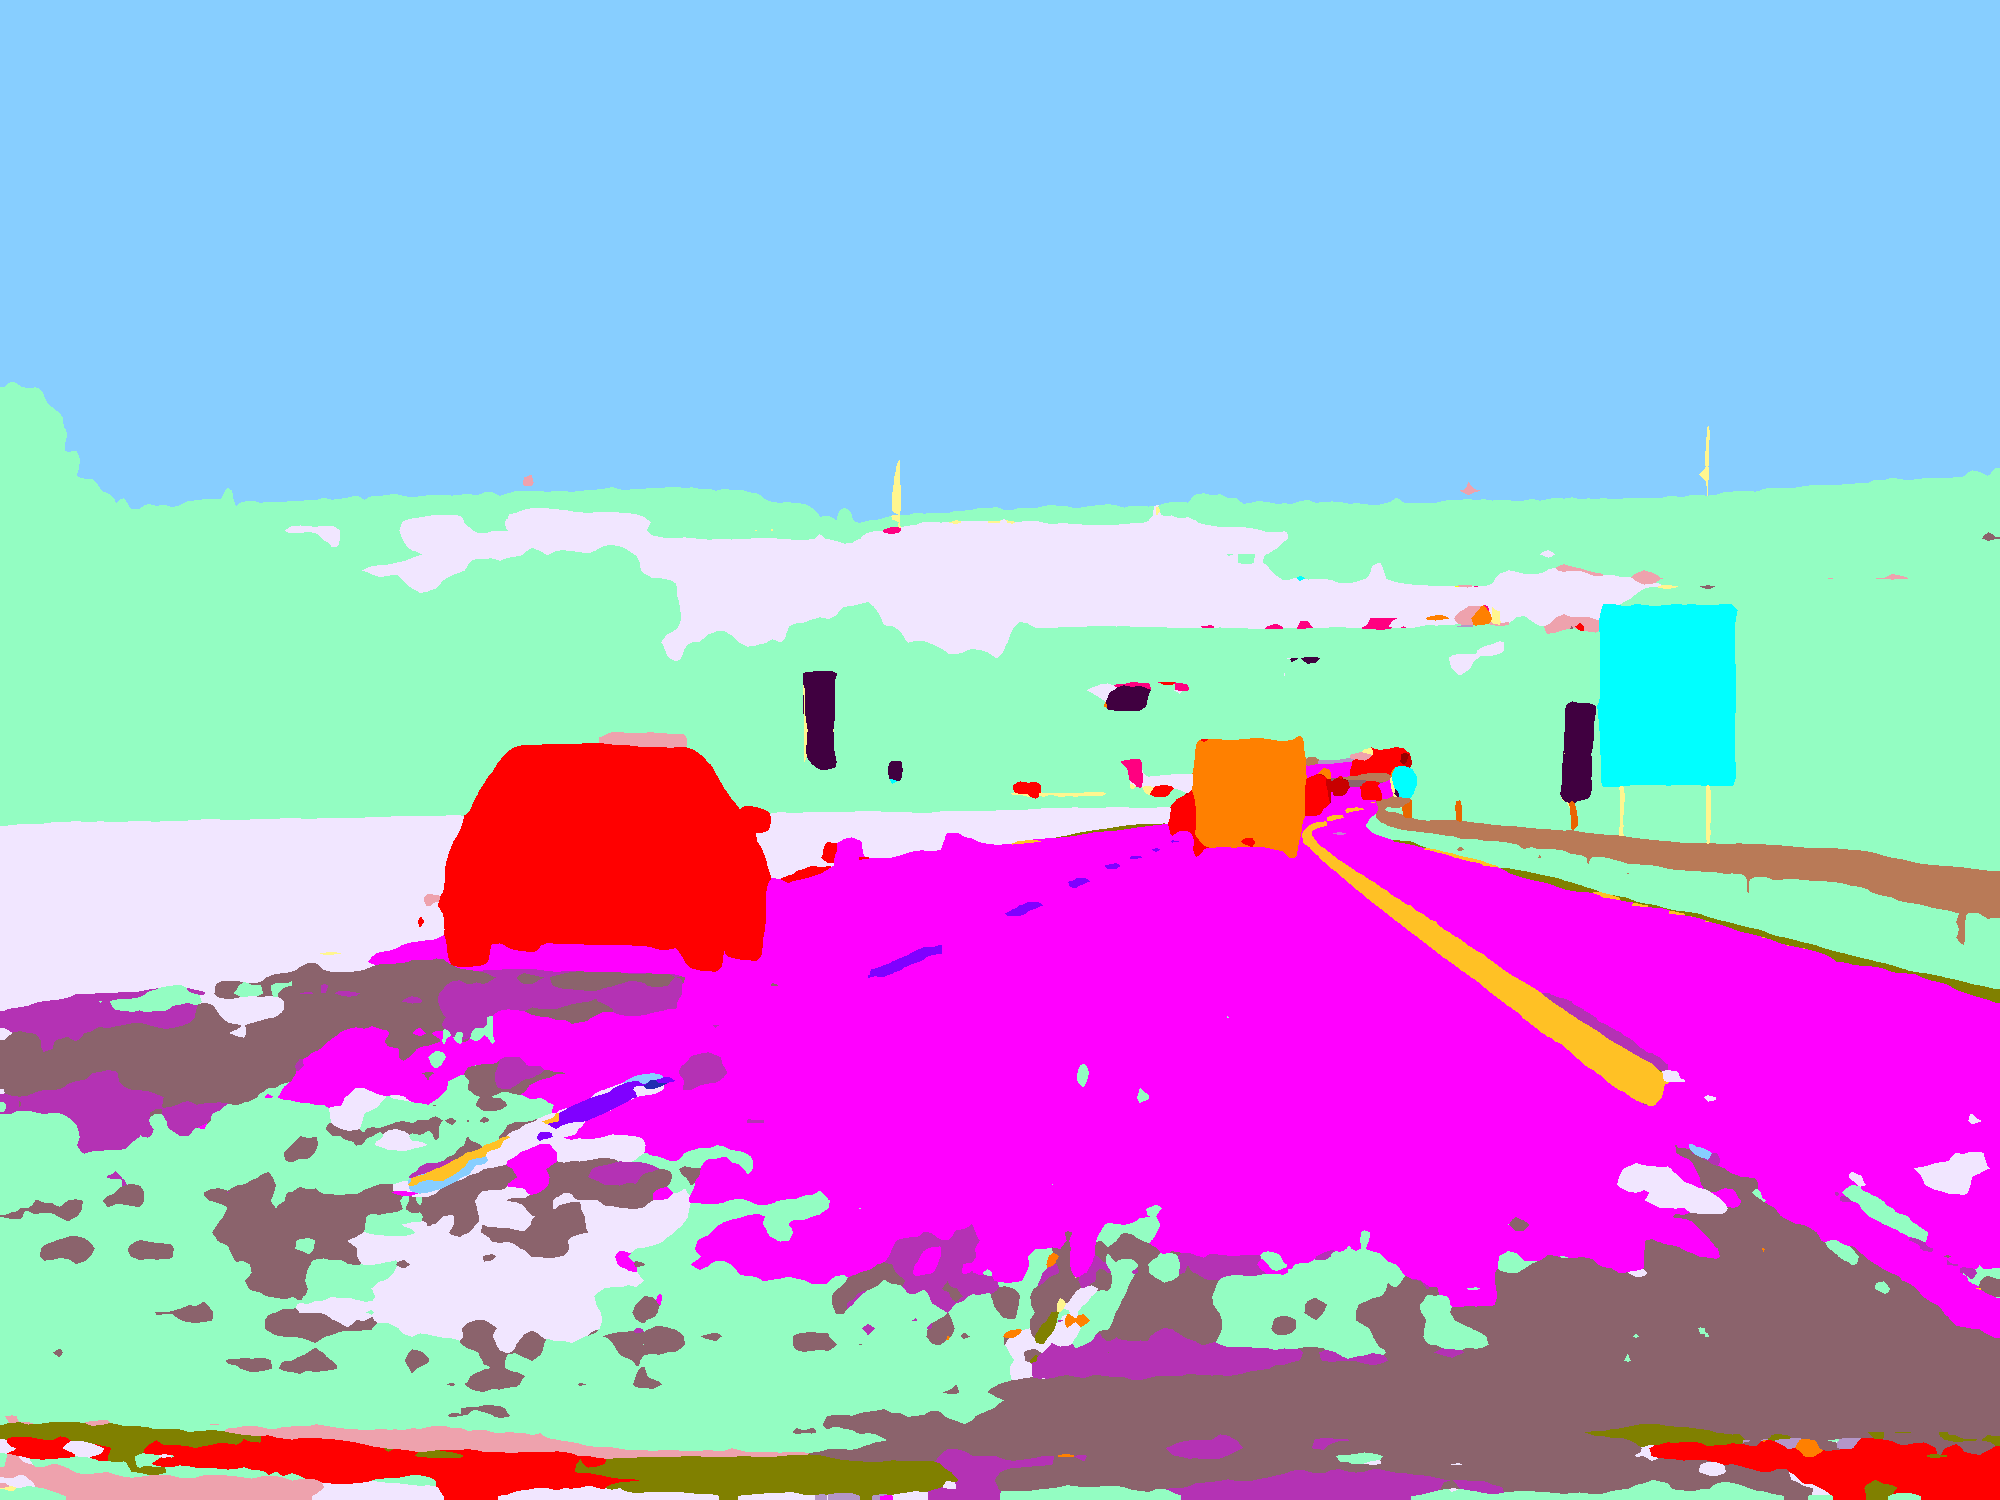

In [8]:
from mask_generation import generate_segmentation_mask_file

generate_segmentation_mask_file(
    device=device,
    checkpoint_path=".\\model\\resnet50_test_5.ckpt",
    input_img_path=".\\test\\test2.png",
    dataset=test_dataset
)